# 04 EEG Preprocess ICA

## Overview

This notebook performs the final preprocessing step on EEG data using Independent Component Analysis (ICA) to identify and remove artifacts. The workflow includes:

1. **Filtering**: Applies bandpass filtering (1-30 Hz) to isolate relevant frequency components
2. **ICA Decomposition**: Decomposes the EEG signal into independent components using the Infomax algorithm
3. **Artifact Classification**: Uses ICLabel to automatically classify ICA components (brain, muscle, eye, heart, line noise, channel noise, other)
4. **Artifact Removal**: Excludes non-brain and non-other components and reconstructs clean EEG data
5. **Visualization**: Plots the preprocessed data for quality inspection

**Input**: `session_XX-EEG-raw.pkl` files (from notebook 02, after RANSAC bad channel removal from notebook 03)

**Output**: `session_XX-EEG-preprocessed.pkl` files containing artifact-removed EEG data ready for ERP analysis

**Prerequisites**: 
- Session mapping CSV must exist
- Raw EEG pickle files must be generated (notebook 02)
- Bad channels identified and removed from channel list (notebook 03)

**Code Attribution:**
- Original EEG preprocessing code adapted from: Chiossi, F., Mayer, S., & Ou, C. (2024). MobileHCI 2024 Papers - Submission 7226.
- OSF Repository: https://osf.io/fncj4/overview (Created: Sep 11, 2023)
- License: GNU General Public License (GPL) 3.0
- Code has been modified for this study's session-based structure and experimental design.


In [16]:
# Install onnxruntime for ICLabel
import sys
!{sys.executable} -m pip install onnxruntime


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
import mne

import os

from mne_icalabel import label_components

from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import datetime
import pyprep
from autoreject import get_rejection_threshold

from tqdm.notebook import trange, tqdm
import pickle

from multiprocessing import Pool

from collections import Counter

## 2. Load Sessions and Select Channels

In [2]:
# Load session mapping
df_sessions = pd.read_csv('./session_mapping.csv')
df_matched = df_sessions[df_sessions['eeg_file'] != 'NO MATCH'].copy()
session_ids = list(df_matched.index)

# Filter to only sessions that have raw pickle files
available_sessions = []
for session_id in session_ids:
    raw_file = f"./preprocessed/session_{session_id:02d}-EEG-raw.pkl"
    if os.path.exists(raw_file):
        available_sessions.append(session_id)
    else:
        print(f"Skipping session {session_id}: {raw_file} not found")
        
session_ids = available_sessions

# NOTE: After running RANSAC (notebook 03), update this list to remove bad channels
# For now, starting with all 64 channels - RANSAC will identify which to remove
chan_names = ['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz', 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'Iz', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'F2', 'AF4', 'AF8']
    
selected_channels = chan_names

print(f"Channel names: {len(chan_names)}")
print(f"Selected channels: {len(selected_channels)}")

print(f"Sessions to process: {len(session_ids)}")
print(f"Session IDs: {session_ids}")

Skipping session 4: ./preprocessed/session_04-EEG-raw.pkl not found
Channel names: 64
Selected channels: 64
Sessions to process: 2
Session IDs: [0, 1]


## 3. High-pass Filter, Low-pass Filter, and ICA

In [6]:
def eeg_preprocessing(session_id, chan_names, l_freq=1, h_freq=None, n_jobs=10, verbose=False):
    """Preprocess EEG data with filtering and ICA."""
    
    dfEEG = pd.read_pickle(f"./preprocessed/session_{session_id:02d}-EEG-raw.pkl")
    
    info = mne.create_info(ch_names=chan_names, sfreq=500, ch_types='eeg', verbose=verbose)
    info.set_montage('standard_1020')
    info['subject_info'] = {"id":session_id}
    info['subject_info'] = {"his_id":str(session_id)}
    
    raw = mne.io.RawArray(dfEEG[chan_names].values.T/1000000, info, verbose=verbose)
    
    # Set average reference before filtering
    raw = raw.set_eeg_reference('average')
    
    # Apply 1-100 Hz filter for ICA (ICLabel requirement)
    # Use method='iir' for much faster filtering (10-20x speedup)
    raw.filter(l_freq=1, h_freq=100, method='iir', verbose=verbose, n_jobs=n_jobs)
    
    # Fit ICA on 1-100 Hz filtered data
    ica = mne.preprocessing.ICA(n_components=20, max_iter='auto', method='infomax', 
                                fit_params=dict(extended=True), verbose=verbose)
    ica.fit(raw)
    
    # Classify ICA components using ICLabel
    ic_labels = label_components(raw, ica, method="iclabel")
    labels = ic_labels["labels"]
    exclude_idx = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]]
    print(f"Excluding these ICA components: {exclude_idx}")
    
    # Apply ICA artifact removal
    ica.apply(raw, exclude=exclude_idx)
    
    # Now apply the final 1-20 Hz filter for ERP analysis
    raw.filter(l_freq=l_freq, h_freq=h_freq, method='iir', verbose=verbose, n_jobs=n_jobs)
    
    # Apply notch filter to remove 50 Hz line noise
    raw.notch_filter(freqs=50, method='iir', verbose=verbose, n_jobs=n_jobs)

    pickle.dump(raw, open(f"./preprocessed/session_{session_id:02d}-EEG-preprocessed.pkl", 'wb'))
    
    return True


In [4]:
%%time

for i, session_id in enumerate(session_ids):
    print(f"\n[{i+1}/{len(session_ids)}] Processing Session {session_id}...")
    result = eeg_preprocessing(session_id, chan_names, l_freq=1, h_freq=20, n_jobs=10)  # Changed from 30 Hz to 20 Hz
    print(f"Session {session_id} completed: {result}")



[1/2] Processing Session 0...


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Computing Extended Infomax ICA
Selecting by number: 20 components
Computing Extended Infomax ICA
Fitting ICA took 440.2s.
Fitting ICA took 440.2s.
Excluding these ICA components: [0, 1, 4, 6, 14, 15]
Applying ICA to Raw instance
Excluding these ICA components: [0, 1, 4, 6, 14, 15]
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Transforming to ICA space (20 components)
    Zeroing out 6 ICA components
    Projecting back using 64 PCA components
    Zeroing out 6 ICA components
    Projecting back using 64 PCA components
Session 0 completed: True

[2/2] Processing Session 1...
Session 0 co

## 4. Plotting Preprocessed EEG Data

Plotting Session 0


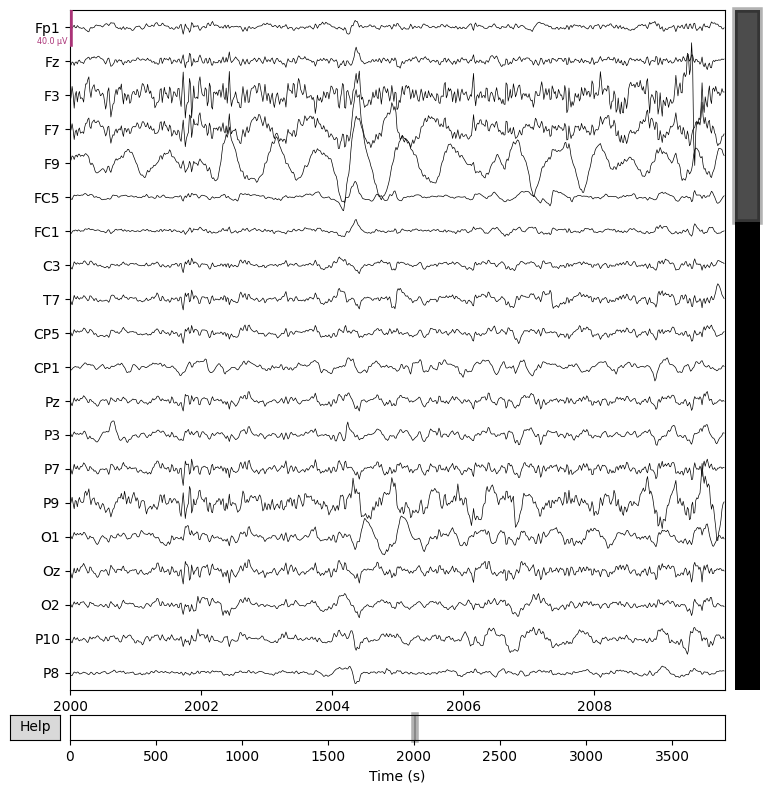

Plotting Session 1


<Figure size 640x480 with 0 Axes>

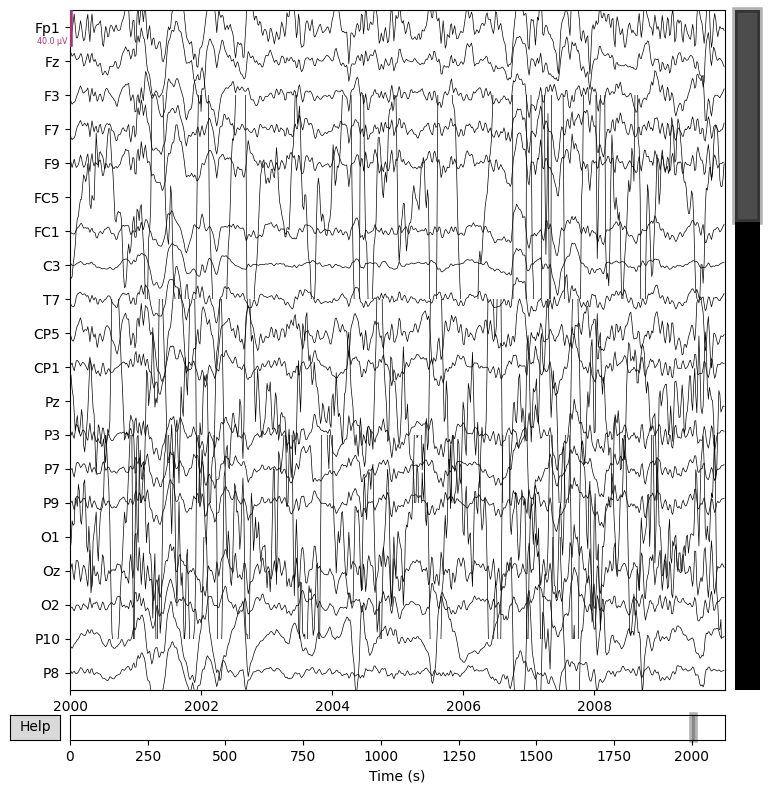

<Figure size 640x480 with 0 Axes>

In [5]:
for session_id in session_ids:
    file = open(f"./preprocessed/session_{session_id:02d}-EEG-preprocessed.pkl",'rb')
    raw = pickle.load(file)
    print(f"Plotting Session {session_id}")
    raw.plot(show=True, verbose=False, start=2000, duration=10.0)

    os.makedirs('./figures', exist_ok=True)
    plt.savefig(f"./figures/raw-filtered-session_{session_id:02d}.jpg",bbox_inches='tight')
